### Connection

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

# Exploratory analysis

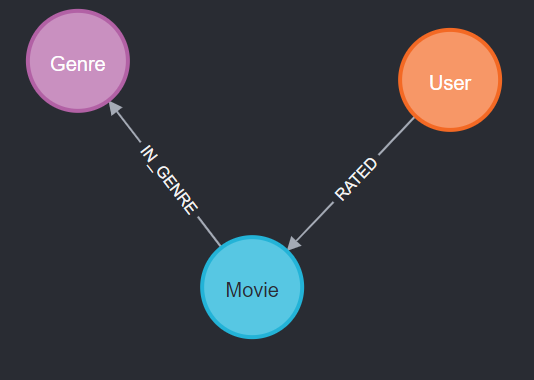

Graph features:
- Directed
- Acyclic
- Unweighted for genre relation and Weighted for rating relation
- Sparse (|edge|<100M)

- todo: system constraints and index in classical and new import
- check for import startup (è meglio creare prima il db, con constraints e indici oppure farlo dopo)
- exploratory analysis normale
- graph analytics con grafi e nodi che aggiungi
- guarda i link della prof e esempi simili
- usa chat gpt

### Distributions of data

<Axes: title={'center': 'Occupation distribution'}, ylabel='count'>

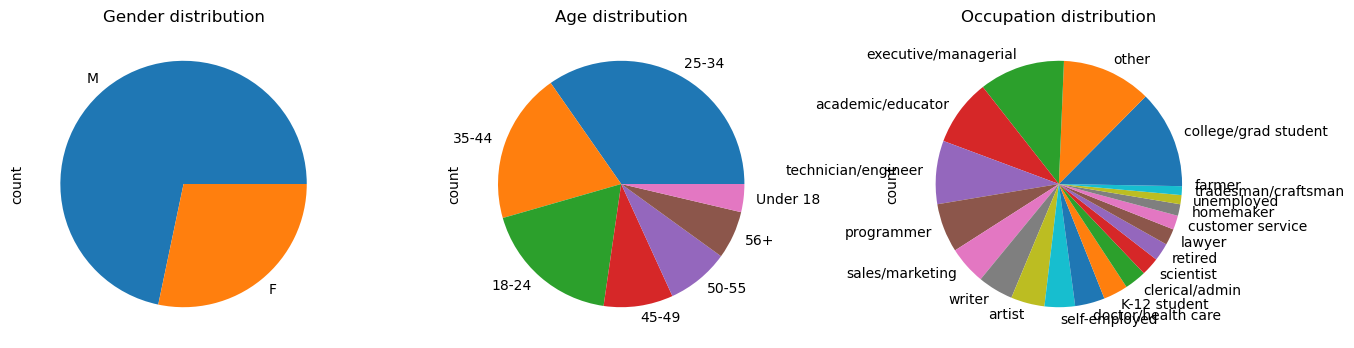

In [5]:
occupation_labels = {
    0: "other",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}
age_labels = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+",
}
users = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.gender as gender,u.age as age,u.occupation as occupation;
"""
)
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
users["gender"].value_counts().plot(kind="pie", ax=ax[0], title="Gender distribution")
users_age = users["age"].value_counts()
users_age = users_age.rename(index=age_labels)
users_age.plot(kind="pie", color="skyblue", title="Age distribution", ax=ax[1])
users_occupation = users["occupation"].value_counts()
users_occupation = users_occupation.rename(index=occupation_labels)
users_occupation.plot(kind="pie", title="Occupation distribution", ax=ax[2])

<Axes: >

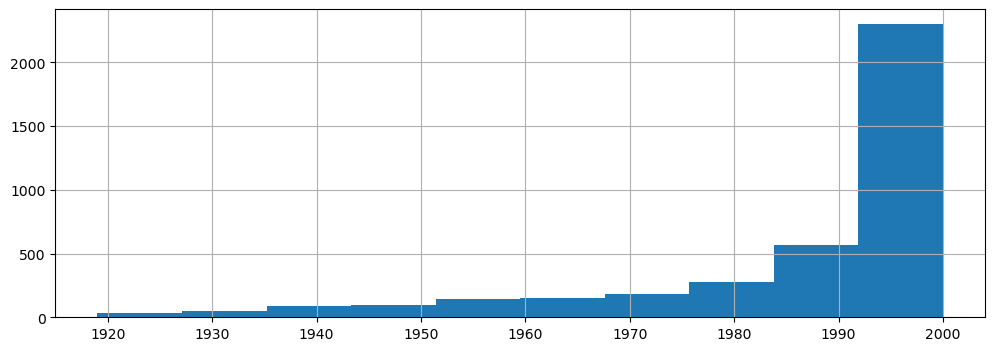

In [6]:
movies = gds.run_cypher(
    """
    MATCH (m:Movie)
    RETURN m.title as title,m.year as year;
"""
)
movies["year"].hist(figsize=(12, 4))

<Axes: xlabel='genre'>

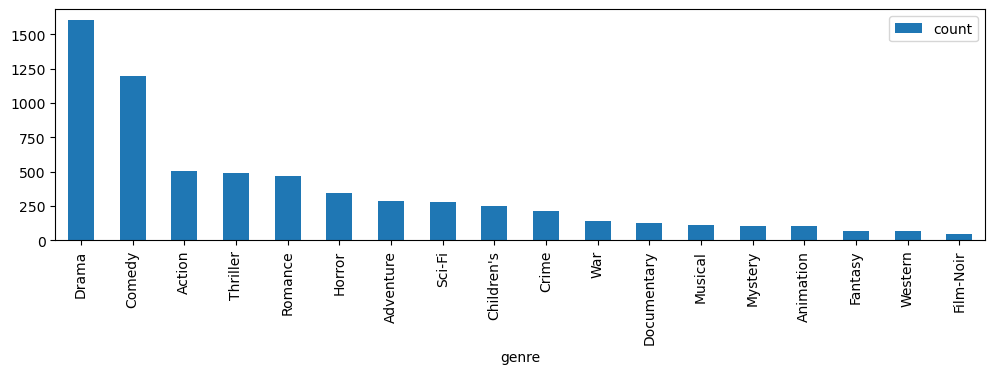

In [7]:
movies_per_genre_distributions = gds.run_cypher(
    """
    MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
    RETURN g.name as genre, COUNT(m) as count
    ORDER BY count DESC;
"""
)
movies_per_genre_distributions.plot(kind="bar", x="genre", y="count", figsize=(12, 3))

<Axes: xlabel='rating'>

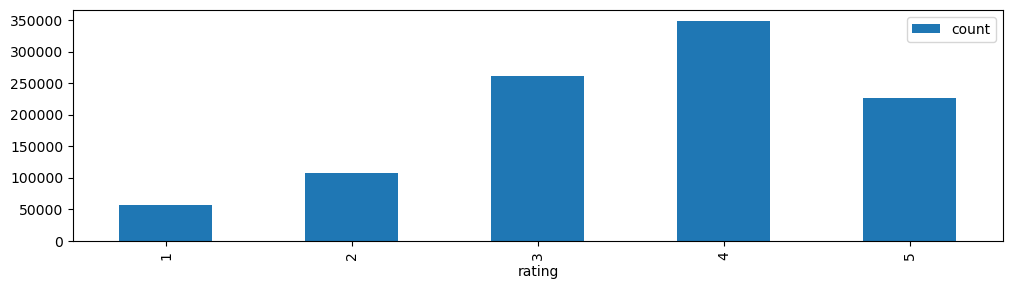

In [8]:
ratings_vote_distribution = gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(m:Movie)
    RETURN r.rating as rating, COUNT(*) as count
    ORDER BY rating;
"""
)
ratings_vote_distribution.plot(kind="bar", x="rating", y="count", figsize=(12, 3))

<Axes: xlabel='year'>

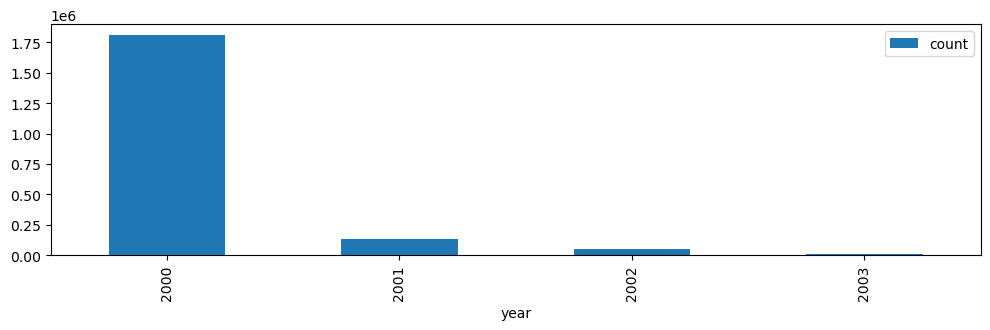

In [9]:
ratings_year_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]-()
    RETURN r.year as year, COUNT(*) as count
    ORDER BY year;

"""
)
ratings_year_distribution.plot(kind="bar", x="year", y="count", figsize=(12, 3))

<Axes: xlabel='month'>

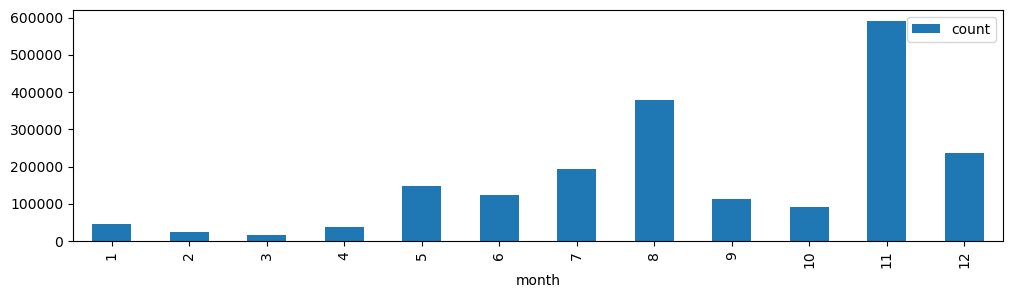

In [10]:
ratings_month_distribution = gds.run_cypher(
    """
    MATCH ()-[r:RATED]-()
    RETURN r.month as month, COUNT(*) as count
    ORDER BY month;

"""
)
ratings_month_distribution.plot(kind="bar", x="month", y="count", figsize=(12, 3))

So to `summarise` these graphs:  
- The users are mostly `male`, `young` (18-44 years old) from different employment sectors (small majority of students and academic people).  
- Most of the films were made between the `1990s` and `2000s`, they are part of the `drama` and `comedy` genre.  
- Most of the reviews are `positive` with a prevalence of a rating of `4`.  
- The ratings were almost all made in the year `2000` and mostly around the months of `November` and `December` (`August` and `July` also has a good frequency) 

### Creation of general graph projections
First of all it be created some graph projection for starting exploration of data.  
- 'movies-graph' with all data
- 'movies-users' with all connection (:User)-[:RATED]->(:Movie)
- 'movies-genres' with all connection (:Movie)-[:IN_GENRE]->(:Genre)

In [11]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-full',
    '*',
    '*'
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-full,"{'__ALL__': {'label': '*', 'properties': {}}}",9941,"{'__ALL__': {'aggregation': 'DEFAULT', 'orient...",1006617


In [12]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-rated',
    ['Movie','User'],
    {
        RATED:{
            orientation: 'REVERSE',
            properties:'rating'
        }
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-rated,"{'User': {'label': 'User', 'properties': {}}, ...",9923,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",1000209


In [18]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-rates',
    ['Movie','User'],
    {
        RATED:{properties:'rating'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)

In [14]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-users',
    ['User', 'Movie'],
    'RATED'
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-users,"{'User': {'label': 'User', 'properties': {}}, ...",9923,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",1000209


In [15]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-genres',
    ['Movie','Genre'],
    'IN_GENRE'
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-genres,"{'Movie': {'label': 'Movie', 'properties': {}}...",3901,"{'IN_GENRE': {'aggregation': 'DEFAULT', 'orien...",6408


## Connectivity Analysis

### Global connectivity
We have no informations about relations of users, so it's useless calculate diameter.  
The graph structure is in general weakly connected so we can do a global analysis of the weakly connected components and see if there are any distinct groups in the network.

In [53]:
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-full")
    YIELD componentCount
    """
).componentCount[0]
print(f"In general graph ther's {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-rated")
    YIELD componentCount
    """
).componentCount[0]
print(f"And also in movies-rated graph ther's {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("users-rates")
    YIELD componentCount
    """
).componentCount[0]
print(f"But in users-rates graph ther're {result} weakly connected component.")

In general graph ther's 1 weakly connected component.
And also in movies-rated graph ther's 178 weakly connected component.
But in users-rates graph ther're 178 weakly connected component.


In [76]:
result = gds.run_cypher(
    """
    CALL gds.wcc.stream("users-rates")
    YIELD nodeId, componentId
    RETURN nodeId AS title, componentId
    ORDER BY componentId, title
    """
)
unique_results = result.nunique()
print(
    f"Uniques values of WCC: {unique_results.title} elements in {unique_results.componentId} groups"
)
unique_results = result[result["componentId"] > 0].nunique()
print(
    f"Uniques values of WCC without first group: {unique_results.title} elements in {unique_results.componentId} groups"
)
print(
    f"So {unique_results.componentId} with 1 node for each groups (excluding the firstone)"
)
result[result["componentId"] > 0]

Uniques values of WCC: 9923 elements in 178 groups
Uniques values of WCC without first group: 177 elements in 177 groups
So 177 with 1 node for each groups (excluding the firstone)


,title,componentId
9746,1142,596
9747,1199,653
9748,1205,659
9749,1233,687
9750,1373,827
...,...,...
9918,9041,8495
9919,9141,8595
9920,9219,8673
9921,9246,8700


So it is possible to say that there's a single great weakly connected components and some outliers node without relations.  
A more in-depth analysis will be done later to identify groups within the network

### Local connectivity
Now it can be see the density and its degree distribution stats.  
This graph was chosen because of its higher density compared with the other datasets available on grouplens 

In [ ]:
result = gds.run_cypher(
    """
    CALL gds.graph.list('movies-full')
    YIELD density,degreeDistribution
"""
)
print(f"Density: {result['density'][0]}")
print(f"Degree distribution: {result['degreeDistribution'][0]}")

Density: 0.010187035096607205
Degree distribution: {'min': 0, 'max': 2314, 'p90': 295, 'p999': 1286, 'p99': 825, 'p50': 35, 'p75': 123, 'p95': 442, 'mean': 101.25912886027562}


Analyzing the degree distribution of the nodes, we can say that the distribution behaves like that of pareto.

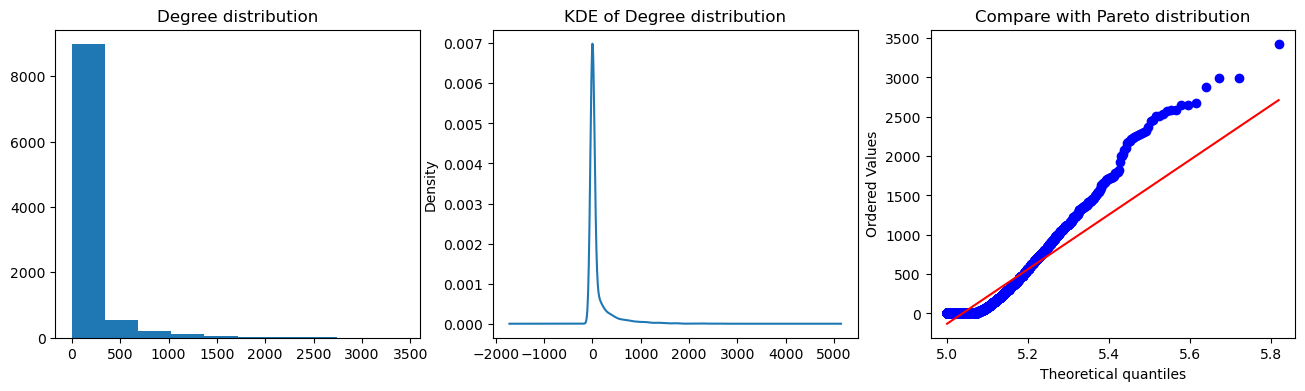

count    9923.000000
mean      100.797037
std       268.554180
min         0.000000
25%         0.000000
50%         0.000000
75%        52.000000
max      3428.000000
Name: score, dtype: float64

In [51]:
result = gds.run_cypher(
    """
    CALL gds.degree.stream("movies-rated")
    """
)
movies_degree = result["score"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(movies_degree, bins=10)
ax[0].set_title("Degree distribution")
movies_degree.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(movies_degree, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()
movies_degree.describe()

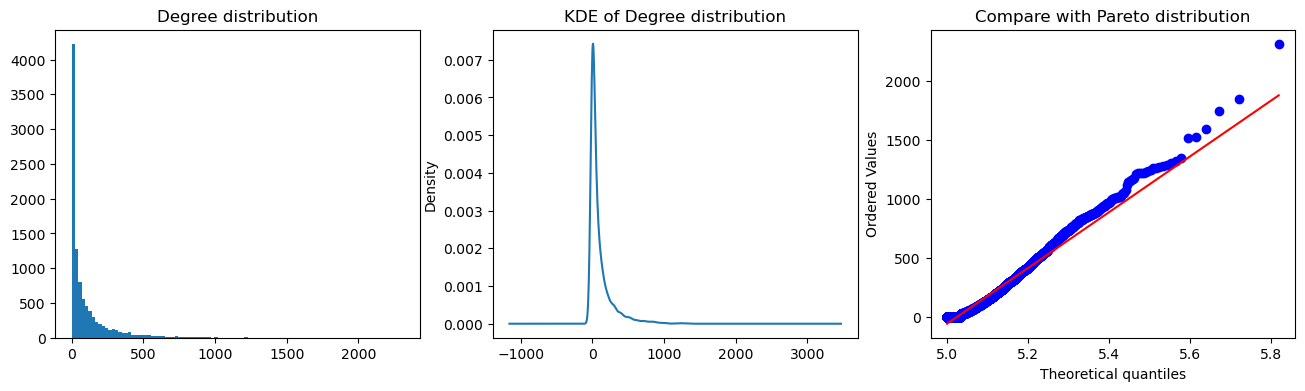

count    9923.000000
mean      100.797037
std       170.717515
min         0.000000
25%         0.000000
50%        35.000000
75%       123.000000
max      2314.000000
Name: score, dtype: float64

In [79]:
result = gds.run_cypher(
    """
    CALL gds.degree.stream("users-rates")
    """
)
users_degree = result["score"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(users_degree, bins=100)
ax[0].set_title("Degree distribution")
users_degree.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(users_degree, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()
users_degree.describe()

Text(0.5, 1.0, 'Boxplot of Users degree distribution')

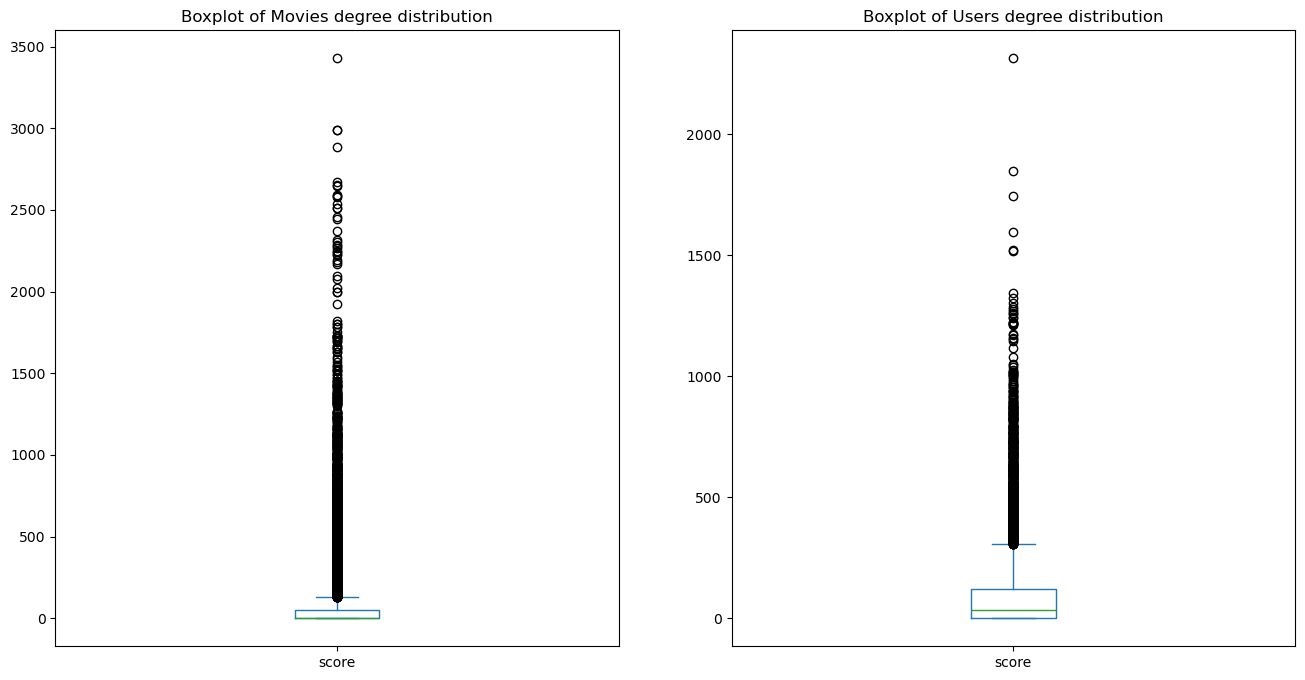

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
movies_degree.plot.box(ax=ax[0])
ax[0].set_title("Boxplot of Movies degree distribution")
users_degree.plot.box(ax=ax[1])
ax[1].set_title("Boxplot of Users degree distribution")

In [74]:
strange_nodes["userId"] = strange_nodes["title"]
app = pd.concat([strange_nodes, users_degree], join="inner", axis=1)

/tmp/ipykernel_1202/3589973847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strange_nodes["userId"] = strange_nodes["title"]


In [75]:
app

,title,componentId,userId,score
9746,1142,596,1142,39.0
9747,1199,653,1199,103.0
9748,1205,659,1205,32.0
9749,1233,687,1233,32.0
9750,1373,827,1373,67.0
...,...,...,...,...
9918,9041,8495,9041,888.0
9919,9141,8595,9141,202.0
9920,9219,8673,9219,20.0
9921,9246,8700,9246,123.0


In [84]:
users_degree[users_degree == 0]

546     0.0
547     0.0
548     0.0
549     0.0
550     0.0
       ... 
9338    0.0
9339    0.0
9340    0.0
9341    0.0
9342    0.0
Name: score, Length: 3883, dtype: float64

#### top 10 movies with the most reviews

In [95]:
movies = gds.run_cypher(
    """
    CALL gds.degree.stream('movies-rated')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).title AS title, score AS ratings
    ORDER BY ratings DESC, title  DESC
  
"""
)

In [96]:
movies

,title,ratings
0,American Beauty (1999),3428.0
1,Star Wars: Episode IV - A New Hope (1977),2991.0
2,Star Wars: Episode V - The Empire Strikes Back...,2990.0
3,Star Wars: Episode VI - Return of the Jedi (1983),2883.0
4,Jurassic Park (1993),2672.0
...,...,...
9918,Associate The (L'Associe)(1982),0.0
9919,Asfour Stah (1990),0.0
9920,Any Number Can Win (M�lodie en sous-sol ) (1963),0.0
9921,Anguish (Angustia) (1986),0.0


#### top 10 users with the most reviews

In [87]:
result = gds.run_cypher(
    """
    CALL gds.degree.stream('users-rates')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).gender AS gender, gds.util.asNode(nodeId).age AS age, gds.util.asNode(nodeId).occupation AS occupation, score AS ratings
    ORDER BY ratings DESC
    
"""
)
result["age"] = result["age"].map(age_labels)
result["occupation"] = result["occupation"].map(occupation_labels)
result

,gender,age,occupation,ratings
0,M,50-55,other,2314.0
1,M,25-34,writer,1850.0
2,M,35-44,self-employed,1743.0
3,M,35-44,technician/engineer,1595.0
4,M,35-44,executive/managerial,1521.0
...,...,...,...,...
9918,None,NaN,NaN,0.0
9919,None,NaN,NaN,0.0
9920,None,NaN,NaN,0.0
9921,None,NaN,NaN,0.0


In [94]:
result[(result["gender"].notnull()) & (result["ratings"] == 0)]

,gender,age,occupation,ratings


TODO:
- capire quei strange nodes cosa sono (devi sistemare title che deve essere veramente il titlo del film)
- correggere le proiezioni
- sistemare quindi l'analisi del grado
- fare beetwennes e closness